In [1]:
class LinProgBaseClass():
    # Consider standard form:
    # min c'x
    # s.t. Ax = b, x>=0
    def __init__(self, A, b, c, x, trace=False):
        (m, n) = A.shape

        # Input shape check:
        if A.shape != (b.shape[0], c.shape[0]):
            raise RuntimeError("Input shape incorrect!")
        # Feasibility check:
        if not np.allclose(A @ x, b):
            raise RuntimeError(
                "initialization not feasible, Ax = {}\nbut b = {}".format(A @ x, b))
        if not np.all(np.greater_equal(x, 0)):
            raise RuntimeError("initialization not feasible, x must >=0")
        self.m = m  # number of equality constraints
        self.n = n  # number of valuables
        self.A = A
        self.c = c  # cost fuction

        self.trace = True
        if trace:
            self.traces = np.empty((1,n))
    
def StandardFormTransformer(A_origin, b, c_origin, x_origin):
    (m, _) = A_origin.shape
    #  2-D array with  1’s as the diagonal and  0’s elsewhere
    A_auxiliary = np.eye(m) 
    # concatinate
    A = np.concatenate((A_origin, A_auxiliary), axis=1)
    x_auxiliary = b - A_origin @ x_origin
    x = np.concatenate((x_origin, x_auxiliary), axis=0)
    c_auxiliary = np.zeros((m, 1))
    c = np.concatenate((c_origin, c_auxiliary), axis=0)
    return A, b, c, x

In [2]:
import numpy as np


class AffineScaling(LinProgBaseClass):

    # epsilon is optimality threshold
    # beta is the stepsize that controling the elipsoid size
    def __init__(self, A, b, c, x, epsilon=1e-2, beta=0.1, trace=False):
        super(AffineScaling, self).__init__(A, b, c, x, trace=trace)

        if beta <= 0 or beta >= 1:
            raise RuntimeError("beta must between (0,1)")
        if epsilon <= 0:
            raise RuntimeError("epsilon must be positive")
        
        # diagonal matrix
        self.X_k = np.diag(x[:, 0]) 
        print(f"X_k diagonal matrix is \n{self.X_k}")
        self.p_k = None
        self.r_k = None
        self.epsilon = epsilon  # optimality threshold
        self.beta = beta

    # reached optimal: return true
    def __OptimalityCheck(self):
        distance = np.sum(self.X_k @ self.r_k)
        print(f"distance = {distance}")
        #  dual feasibliity and optimality
        return distance > 0 and distance < self.epsilon

    # unbounded: return true
    def __UnboundenessCheck(self):
        reduced_cost = - self.X_k @ self.X_k @ self.r_k
        return np.all(np.greater_equal(reduced_cost, 0))

    def __Caculate_r(self):
        # calculate W_k computation of dual estimates
        self.p_k = np.linalg.inv(self.A @ self.X_k @ self.X_k @ np.transpose(
            self.A)) @ self.A @ self.X_k @ self.X_k @ self.c
        # calculate r_k computation of reduced costs
        self.r_k = self.c - np.transpose(self.A) @ self.p_k

    def __Update_X(self):
        move = self.X_k @ self.X_k @ self.r_k / self.__gamma(self.X_k @ self.r_k)
        move = np.diag(move[:, 0])
        self.X_k = self.X_k - self.beta * move
    
    def __gamma(self, input):
        clipped = np.clip(input, 0, None)
        return np.max(clipped)

    def Run(self): 
        self.__Caculate_r()
        while not self.__OptimalityCheck(): # check for optimality
            if self.__UnboundenessCheck(): # check for unboundedness 
                print("the input LP problem is unbounded")
                return None
            self.__Update_X()
            self.__Caculate_r()
            if self.trace:
                expanded_X = np.expand_dims(np.diag(self.X_k),axis=0)
                print(f"expanded_X = {expanded_X}")
                self.traces = np.concatenate((self.traces,expanded_X),axis=0)
        return np.diag(self.X_k)
    
    def GetTraces(self):
        return self.traces

In [3]:
# LP problem in standard
eps = 0.1
offset = 0.05
epsilon = 0.1
# LPP problem inputs
A_origin = np.asarray([[1,-1,1,0],
                       [0,1,0,1]])
b = np.asarray([[15,15]]).T
c_origin = np.asarray([[-2, 1, 0, 0]]).T
x_origin = np.asarray([[10, 2, 7, 13]]).T

In [4]:
# convert to standart form
(A, _, c, x) = StandardFormTransformer(A_origin, b, c_origin, x_origin)
print(f"Standart form\n A\n{A}\n b\n{b}\n c\n{c}\n x\n{x}")

Standart form
 A
[[ 1. -1.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.]]
 b
[[15]
 [15]]
 c
[[-2.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
 x
[[10]
 [ 2]
 [ 7]
 [13]
 [ 0]
 [ 0]]


X_k diagonal matrix is 
[[10  0  0  0  0  0]
 [ 0  2  0  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]
distance = 2.1187010925036835
expanded_X = [[10.71396174  2.01396174  6.3        12.98603826  0.          0.        ]]
distance = 2.862888498446136
expanded_X = [[11.36417866  2.03417866  5.67       12.96582134  0.          0.        ]]
distance = 3.317304694342026
expanded_X = [[11.95751426  2.06051426  5.103      12.93948574  0.          0.        ]]
distance = 3.525875101887745
expanded_X = [[12.50052299  2.09322299  4.5927     12.90677701  0.          0.        ]]
distance = 3.541660984877797
expanded_X = [[12.99945636  2.13288636  4.13343    12.86711364  0.          0.        ]]
distance = 3.4145968246812903
expanded_X = [[13.46031967  2.18040667  3.720087   12.81959333  0.          0.        ]]
distance = 3.186500085652218
expanded_X = [[13.88896482  2.23704312  3.3480783  12.76295688  0.          0.        ]]
distance = 2.89005517

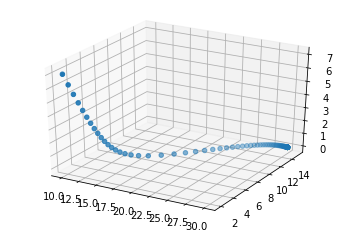

In [6]:
# matplotlib figure setup
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Affine Scaling, plot in blue
solver = AffineScaling(A, b, c, x, epsilon=1e-5, trace=True)
result = solver.Run()
traces = solver.GetTraces()
x1, x2, x3 = traces[:,:3].T
ax.scatter(x1, x2, x3)
plt.show()